<a href="https://colab.research.google.com/github/Nov05/DS-Unit-1-Sprint-4-Linear-Algebra/blob/master/module3-dimensionality-reduction/High_Dimensional_Data_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# modified by nov05 on 2019-06-19
# DS-Unit-1-Sprint-4-Linear-Algebra-master/
# module3-dimensionality-reduction/

**Lecture Notebook**  
https://colab.research.google.com/drive/19eXBnbYmtFFrNjqtLpnfdXoOMRSaS-1f  
https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb  
my PyTorch code  
https://github.com/Nov05/Google-Colaboratory/blob/master/densenet169v2.ipynb  

# Imports

In [0]:
# Update PIL version to later than 4.0.0 or you might encounter the following error.
# AttributeError: module 'PIL.Image' has no attribute 'register_extensions'
!pip install --no-cache-dir -I pillow
# Successfully installed pillow-6.2.0

     |████████████████████████████████| 2.1MB 8.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
# Restart runtime before running this code block if new PIL installed
import torch
print("PyTorch version: ", torch.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version is: ", torch.backends.cudnn.version())
print('Device:', torch.device('cuda:0'))

import PIL
print('Python PIL version:', PIL.PILLOW_VERSION)

PyTorch version:  1.3.0+cu100
CUDA version:  10.0.130
cuDNN version is:  7603
Device: cuda:0
Python PIL version: 6.2.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from scipy.io import loadmat
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from matplotlib import ticker 
from matplotlib import cm
import matplotlib.gridspec as gridspec
import seaborn as sns

import json
import time
import datetime

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.debugger import Tracer
import warnings
warnings.filterwarnings('ignore')

# MIT Faces Recognition Project database   

http://courses.media.mit.edu/2004fall/mas622j/04.projects/faces/ 

### Reading Unsigned Integer Files

/content/drive/My Drive/data/mitfaces/raw/1227


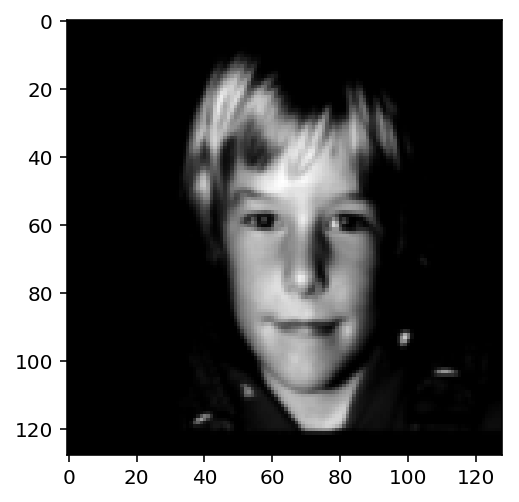

In [0]:
# display the original face
def display_face(filename="1227"):
    path = '/content/drive/My Drive/data/mitfaces/raw/' + filename
    print(path)
    raw = np.fromfile(path, dtype='uint8', sep="")
    img = np.reshape(raw, (128, 128))
    plt.imshow(img, cmap="gray")
    
display_face()

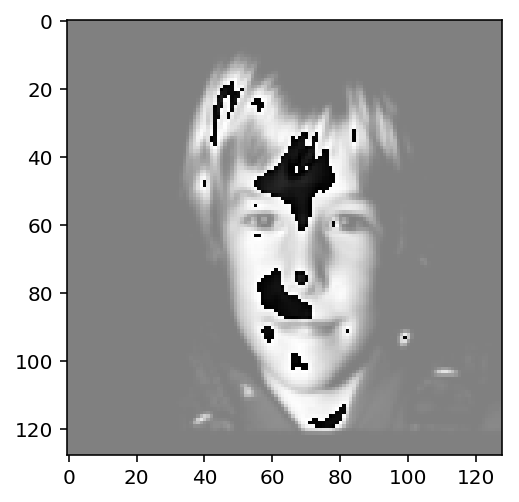

In [0]:
#【CAUTION】【CAUTION】【CAUTION】
# if dtype="int8", grayscale will not be displayed properly
# this is an example of imporper reading of unsigned integer files
path = '/content/drive/My Drive/data/mitfaces/raw/1227'
raw = np.fromfile(path, dtype='int8', sep="")
img = np.reshape(raw, (128, 128))
plt.imshow(img, cmap="gray");

You can now find the mean face and 99 eigenfaces in the Matlab MAT-file ev.mat.    
The list of images used for training the eigenspace is in train_list.   

```
load ev.mat
load faceR
v = faceR(5, 2:100)';
i = eigenfaces'*v + mean_face';
imagesc(reshape(i, 128, 128)'); colormap(gray(256));
```

In [0]:
'''
Two of the files, faceR and faceS, contain 99 coefficients for each of 2000 faces. 
faceR should be used as training data; faceS for testing. Each row contains 100 elements. 
The first element of each row contains a face number (running from 1223 to 5223); 
the remaining 99 are coefficients measuring how much that face projects onto the corresponding eigenvector.
'''
path = "/content/drive/My Drive/data/mitfaces/faces/faceR"
with open(path) as f:
    faceR = f.read().splitlines()
    
arr = []
for str in faceR:
    row = str.strip().split(' ')
    arr.append(row)
    
df_faceR = pd.DataFrame(arr).set_index(0)
del df_faceR.index.name
df_faceR = df_faceR.iloc[:,:99]
df_faceR = df_faceR.replace(' ', '')
for col in df_faceR.columns:
    df_faceR[col] = pd.to_numeric(df_faceR[col])
    df_faceR = df_faceR.replace(np.nan, 0)
print('number of nan:', df_faceR.isnull().sum().sum())
print(df_faceR.shape)
df_faceR.head(2)

number of nan: 0
(2000, 99)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
1223,-1779.619019,2107.30127,807.759949,-654.226135,322.416931,1075.673706,559.180786,452.465454,-561.820374,74.668030,67.978477,198.796906,22.676338,-172.910126,306.917023,154.041595,-403.840271,-66.760246,100.143784,-189.239578,35.033672,-291.399200,-12.720598,120.488663,-325.439758,-237.672791,-162.531113,-184.136658,214.378540,-168.662018,193.702835,-253.508377,-270.742218,293.662354,-15.763512,130.660538,-39.088024,-209.809036,112.635559,-54.906422,...,144.796448,13.325173,-80.345116,20.910030,-85.240402,-57.382092,0.000000,9.731221,64.159706,41.712112,139.698776,131.256653,-123.708351,-81.298141,-85.131653,39.110416,229.450867,-74.828201,164.768158,76.867096,-55.710514,-38.79393,146.945541,-168.382278,16.658672,257.251373,140.037918,131.178085,-97.415123,185.057739,-91.611031,117.541168,-12.968436,253.902130,-180.755005,120.39035,207.105194,144.583420,-86.194237,12.877232
1224,-2719.973389,2978.84375,-12.276579,-146.023010,1998.795898,1465.912964,-365.699615,918.354187,280.471558,445.049927,178.193985,147.827362,716.902649,-766.267090,72.461349,-400.456055,-386.995270,160.249146,681.609802,351.122772,269.915588,99.293045,-364.092255,37.977070,-767.973816,-194.574677,-1087.563110,250.003555,323.815887,220.343307,-21.066364,-10.117967,-520.816895,15.891185,202.479507,28.905891,341.736816,-346.856110,132.188416,-250.847702,...,-72.969856,324.703918,287.035309,-210.070953,138.432144,165.274796,89.772202,105.582329,81.803932,216.312668,-118.580460,-13.755272,-33.028538,-147.328674,111.182686,45.534718,14.858976,149.564209,131.116196,-9.298961,-267.542358,105.23867,-216.905365,-44.852470,14.946404,122.405769,152.860138,-11.191414,-140.634018,-180.091751,82.291786,279.086487,76.618538,130.531647,53.132874,-51.56419,138.686768,-46.186413,-4.687377,-42.803467


In [0]:
# import matlab file
from scipy.io import loadmat
path = "/content/drive/My Drive/data/mitfaces/faces/ev.mat"
dict_ev = loadmat(path)
dict_ev

{'eigenfaces': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'ev100': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'mean_face': array([[0., 0., 0., ..., 0., 0., 0.]])}

In [0]:
print('99 eigenfaces:', dict_ev['eigenfaces'].shape)
print('ev100?:', dict_ev['ev100'].shape)
print('mean face:', dict_ev['mean_face'].shape)

99 eigenfaces: (99, 16384)
ev100?: (1, 16384)
mean face: (1, 16384)


In [0]:
# get list of faces that were used for training
path = "/content/drive/My Drive/data/mitfaces/faces/train_list"
with open(path) as f:
    train_list = f.read().splitlines()
print('train list length:', len(train_list))
print(train_list)

train list length: 101
['1227', '1234', '1262', '1266', '1290', '1313', '1353', '1400', '1414', '1451', '1456', '1494', '1513', '1599', '1600', '1601', '1616', '1657', '1671', '1681', '1727', '1762', '1772', '1802', '1805', '1861', '1872', '1900', '1911', '1913', '1927', '1945', '1986', '2005', '2013', '2024', '2029', '2063', '2065', '2074', '2090', '2095', '2104', '2117', '2132', '2158', '2181', '2185', '2203', '2225', '2229', '2251', '2263', '2321', '2322', '2336', '2349', '2370', '2393', '2425', '2449', '2451', '2465', '2466', '2474', '2475', '2479', '2494', '2495', '2505', '2524', '2526', '2539', '2550', '2618', '2661', '2680', '2685', '2725', '2735', '2746', '2770', '2776', '2781', '2807', '2834', '2853', '2899', '2935', '2937', '2955', '2957', '2983', '2996', '3022', '3039', '3057', '3116', '3133', '3155', '3178']


### Read file - Original faces

https://docs.scipy.org/doc/numpy/user/basics.types.html  
```
Numpy type	C type	Description
np.int8	int8_t	Byte (-128 to 127)
np.int16	int16_t	Integer (-32768 to 32767)
np.int32	int32_t	Integer (-2147483648 to 2147483647)
np.int64	int64_t	Integer (-9223372036854775808 to 9223372036854775807)
np.uint8	uint8_t	Unsigned integer (0 to 255)
```

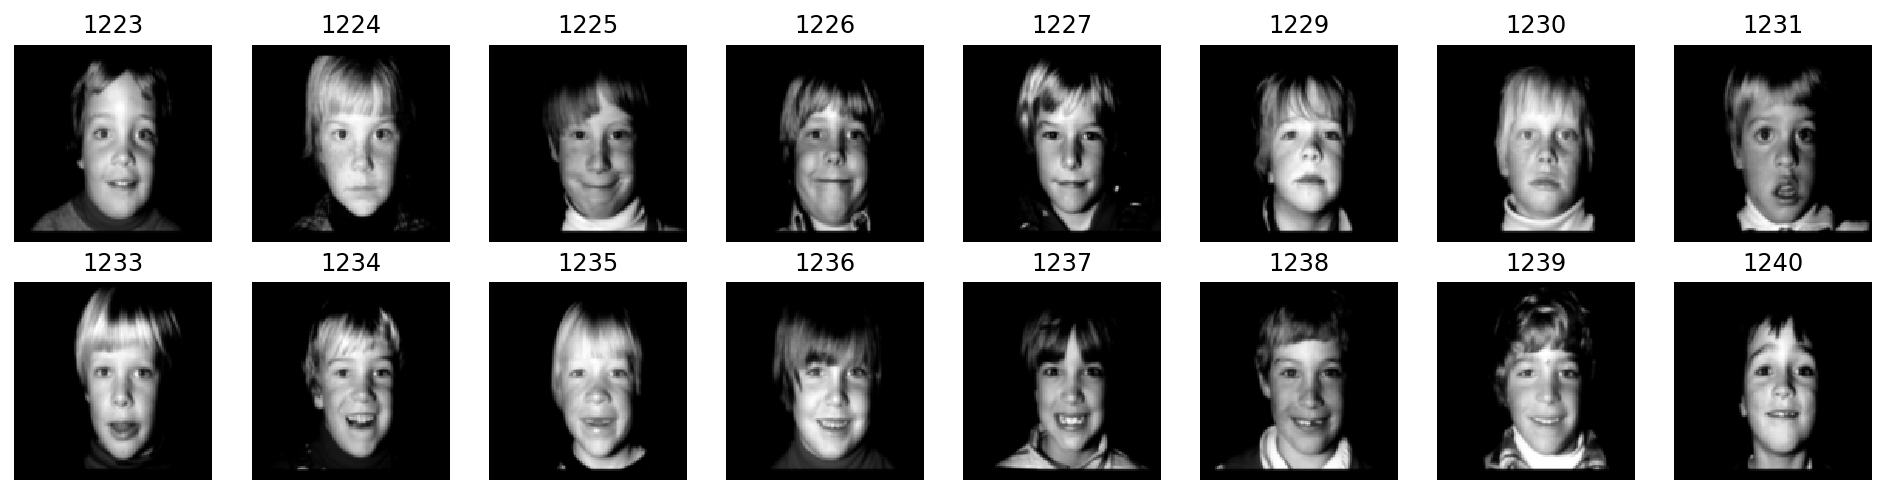

In [0]:
fig, axes = plt.subplots(2,8, figsize=(17,4))
count = 0
for i in range(50):
    filename = df_faceR.index[i]
    path = '/content/drive/My Drive/data/mitfaces/raw/' + filename
    try:
        #【CAUTION】if dtype="int8", grapscale will not be displayed properly
        raw = np.fromfile(path, dtype='uint8', sep="")
    except FileNotFoundError:
        continue
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count]
    ax.imshow(img, cmap="gray")
    ax.set_title(filename)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    count += 1
    if count >= 16:
        break
        
fig.subplots_adjust(hspace=0.2, wspace=0);

### Read file - Mean face

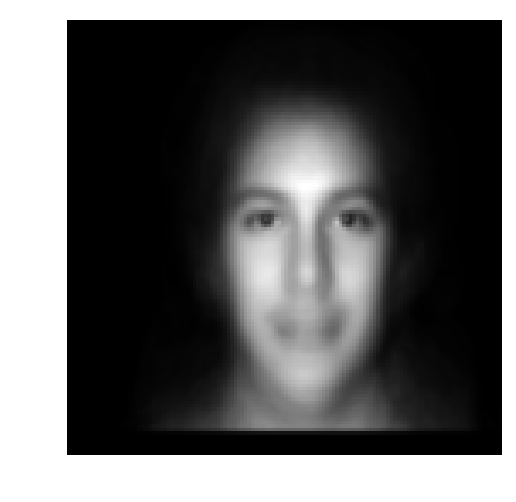

In [0]:
# mean face
raw_mean = dict_ev['mean_face']
img = np.reshape(raw_mean, (128, 128))
plt.imshow(img, cmap="gray")
plt.axis('off');

### Read file - Eigenfaces

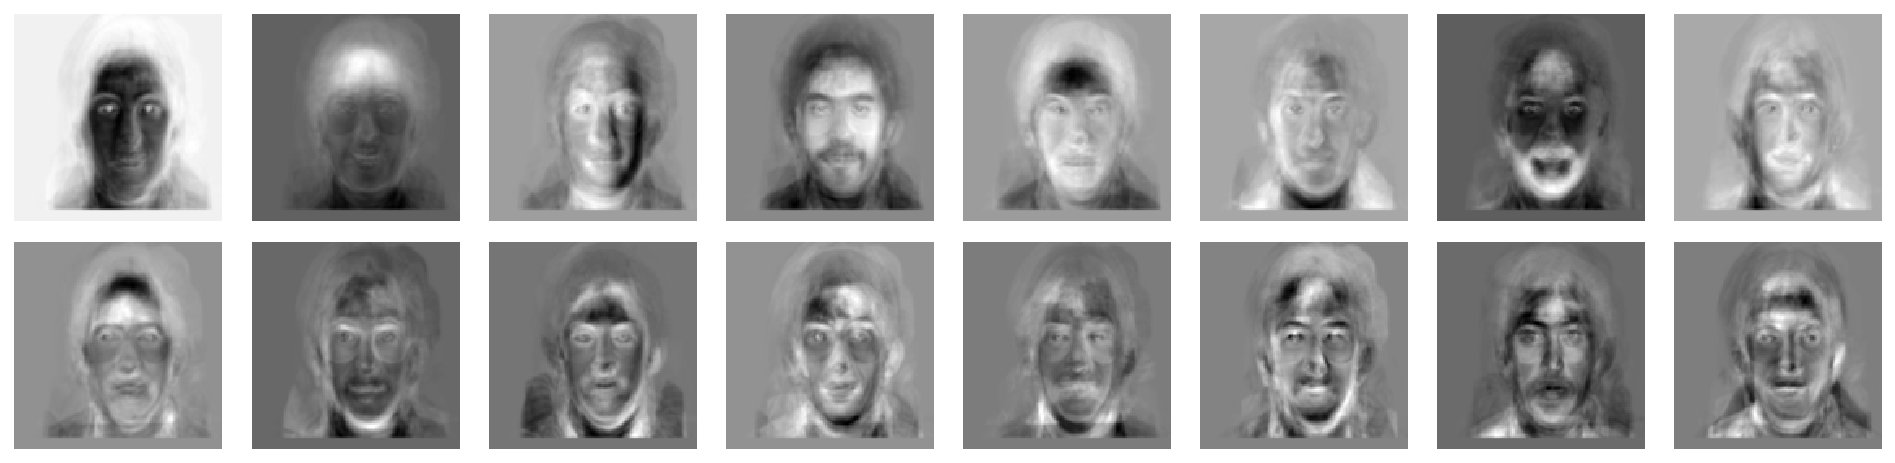

In [0]:
# 99 eigenfaces
fig, axes = plt.subplots(2,8, figsize=(17,4))
for i in range(16):
    raw = dict_ev['eigenfaces'][i]
    img = np.reshape(raw, (128, 128))
    axes.flat[i].imshow(img, cmap="gray")
    axes.flat[i].set_xticklabels([])
    axes.flat[i].set_yticklabels([])
    axes.flat[i].axis('off')
fig.subplots_adjust(hspace=0.1, wspace=0);

### Reconstruct faces

In [0]:
# faceR (train) and faceS (test), contain 99 coefficients for 2000 faces
print(df_faceR.loc['1227'].values.shape)
print(dict_ev['eigenfaces'].T.shape)
print(dict_ev['mean_face'].T.shape)

(99,)
(16384, 99)
(16384, 1)


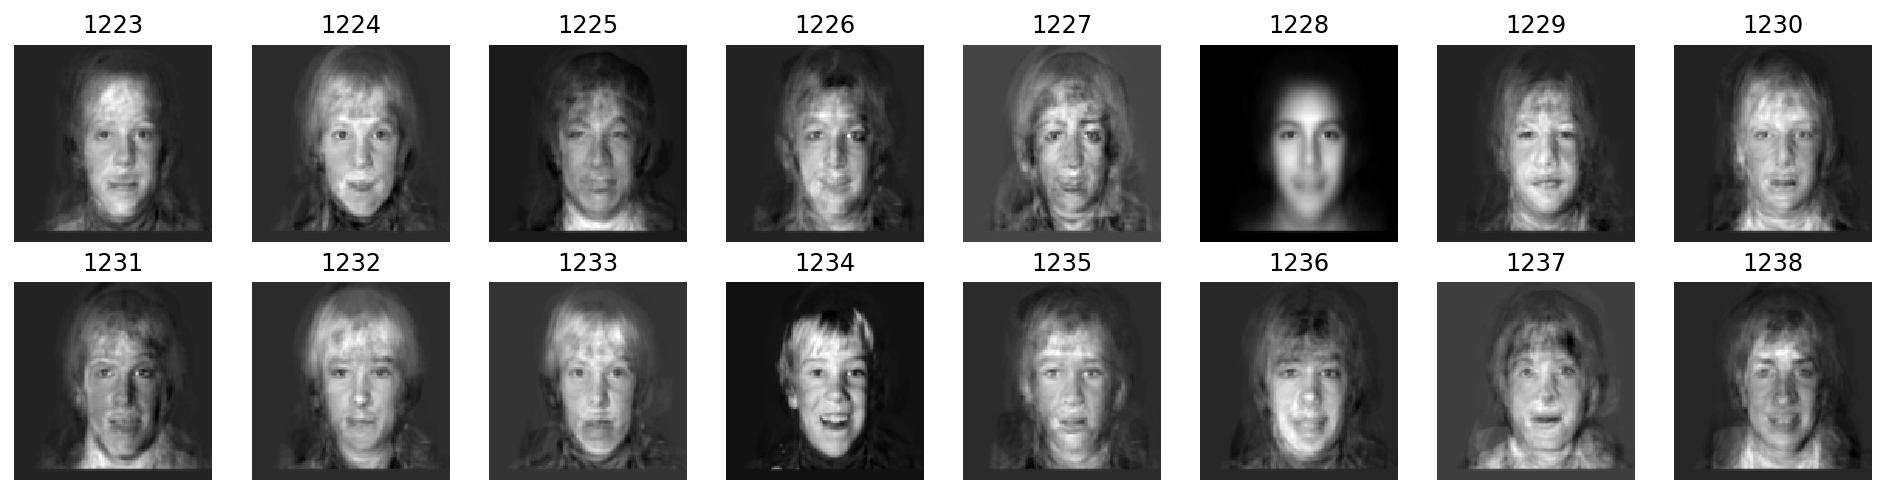

In [0]:
# re-construct the faces
# i = eigenfaces' * v + mean_face'
fig, axes = plt.subplots(2,8, figsize=(17,4))
for i in range(16):
    raw = np.matmul(df_faceR.iloc[i,:].values, dict_ev['eigenfaces']) \
        + dict_ev['mean_face']
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[i]
    ax.imshow(img, cmap="gray")
    ax.set_title(df_faceR.index[i])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
fig.subplots_adjust(hspace=0.2, wspace=0);

#【CAUTION】1228 is the mean face... i have no idea why it is here.

### Compare original and reconstructed faces

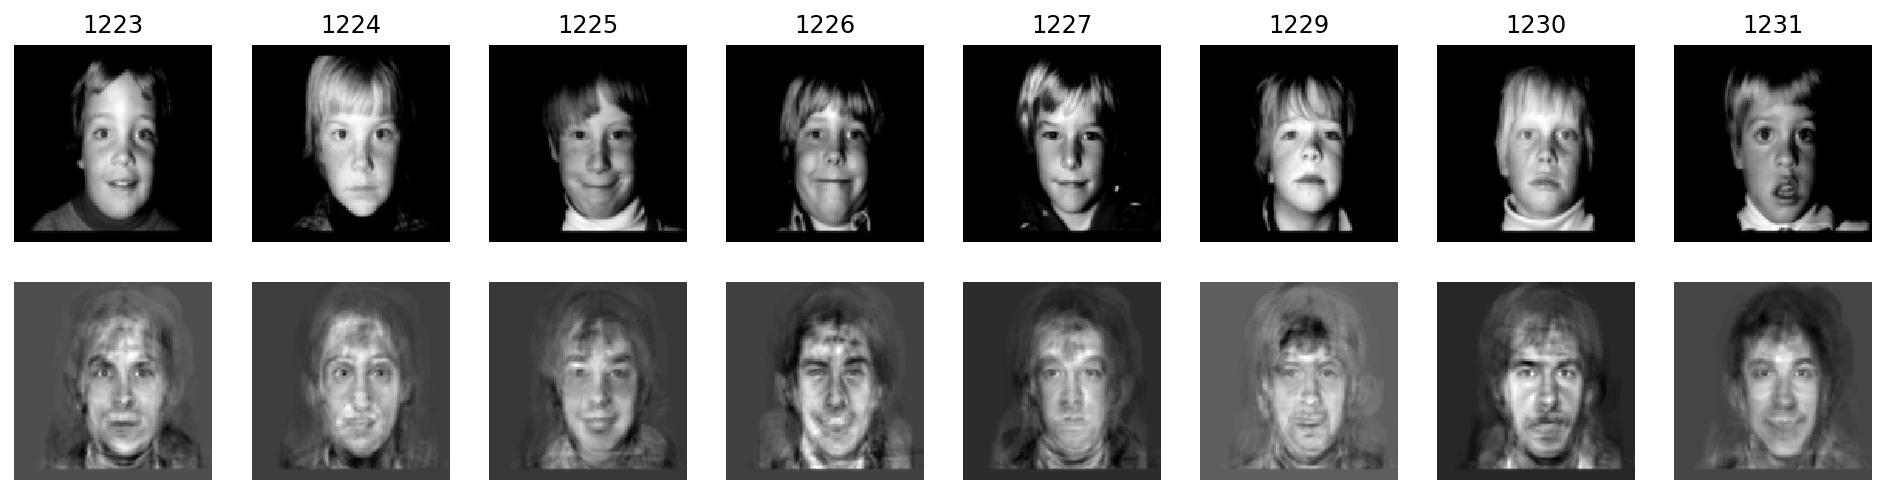

In [0]:
# compare original and reconstructed faces   
fig, axes = plt.subplots(2,8, figsize=(17,4))
count = 0
for i in range(50):
    filename = df_faceR.index[i]
    path = '/content/drive/My Drive/data/mitfaces/raw/' + filename
    try:
        raw = np.fromfile(path, dtype='uint8', sep="")
    except FileNotFoundError:
        continue
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count]
    ax.imshow(img, cmap="gray")
    ax.set_title(filename)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    raw = np.matmul(df_faceR.loc[filename].values, dict_ev['eigenfaces']) + dict_ev['mean_face']
## coeffciences and mean face are the same, the only difference is the eigenfaces    
#     raw = np.matmul(arr_svd[i], dict_ev['eigenfaces']) + mean_face 
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count+8]
    ax.imshow(img, cmap="gray")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    count += 1
    if count >= 8:
        break
        
fig.subplots_adjust(hspace=0.2, wspace=0);

# 101 training faces

### Reproduce mean face

In [0]:
# read all images in train list
train = []
for filename in train_list:
    path = '/content/drive/My Drive/data/mitfaces/raw/' + filename
    try:
        raw = np.fromfile(path, dtype='uint8', sep="")
        train.append(raw.tolist())
    except FileNotFoundError:
        continue    
df_train = pd.DataFrame(train)
del train

In [0]:
print(df_train.shape)
df_train.iloc[:2,:20]

(101, 16384)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


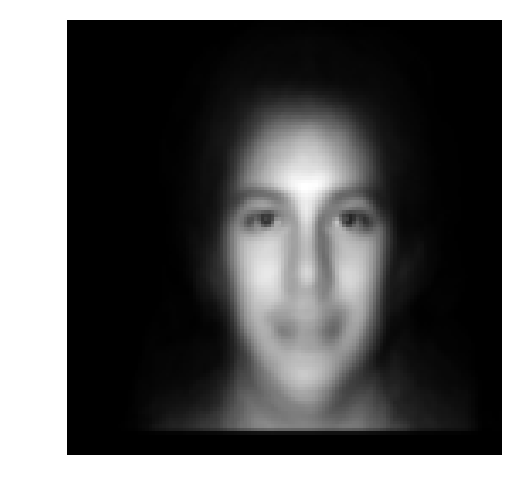

In [0]:
meanface = df_train.mean().to_list()
img = np.reshape(meanface, (128, 128))
plt.imshow(img, cmap="gray")
plt.axis('off');

(50, 16384)


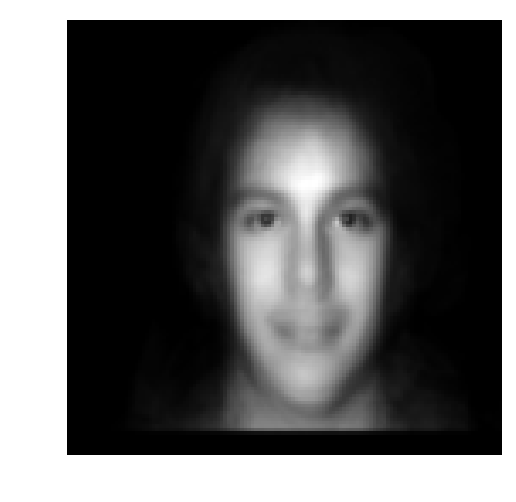

In [0]:
df_sample = df_train.sample(50)
print(df_sample.shape)
meanface_sample = df_sample.mean().to_list()
img = np.reshape(meanface_sample, (128, 128))
plt.imshow(img, cmap="gray")
plt.axis('off');


### Reproduce eigenfaces

https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/    
<img src="https://sandipanweb.files.wordpress.com/2017/12/f1.png" width=800>    

**sklearn.decomposition.PCA**   
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html   
**sklearn.decomposition.TruncatedSVD**     
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html    
https://en.wikipedia.org/wiki/Singular_value_decomposition   

In [0]:
# center the data first
df_centered = df_train - mean_face
df_centered.shape

(101, 16384)

In [0]:
%%time
# svd = TruncatedSVD(n_components=99, n_iter=7, random_state=42)
svd = TruncatedSVD(n_components=99)
arr_svd = svd.fit_transform(df_centered)
print('svd.explained_variance_ratio_.sum():', svd.explained_variance_ratio_.sum()) 

print(arr_svd.T.shape, df_train.shape)
eigenfaces_svd = np.matmul(arr_svd.T, df_train.values)
print(svd_eigenfaces.shape)

svd.explained_variance_ratio_.sum(): 0.9997531249249254
(99, 101) (101, 16384)
(99, 16384)
CPU times: user 1.18 s, sys: 517 ms, total: 1.69 s
Wall time: 873 ms


In [0]:
%%time

# pca = PCA(n_components=99)
pca = PCA(n_components=99)
arr_pca = pca.fit_transform(df_train)
print('pca.explained_variance_ratio_.sum():', pipeline['pca'].explained_variance_ratio_.sum())  
eigenfaces_pca = np.matmul(arr_pca.T, df_train.values)

pca = PCA(n_components=99, whiten=True)
arr_pca_whiten = pca.fit_transform(df_train)
eigenfaces_pca_whiten = np.matmul(arr_pca_whiten.T, df_train.values)

pipeline = Pipeline([('scaling', StandardScaler()), 
                     ('pca', PCA(n_components=99, whiten=True))])
arr_pca_standardized = pipeline.fit_transform(df_train)
eigenfaces_pca_standardized = np.matmul(arr_pca_standardized.T, df_train.values)

pca.explained_variance_ratio_.sum(): 0.9998099437596724
CPU times: user 1.02 s, sys: 237 ms, total: 1.25 s
Wall time: 950 ms


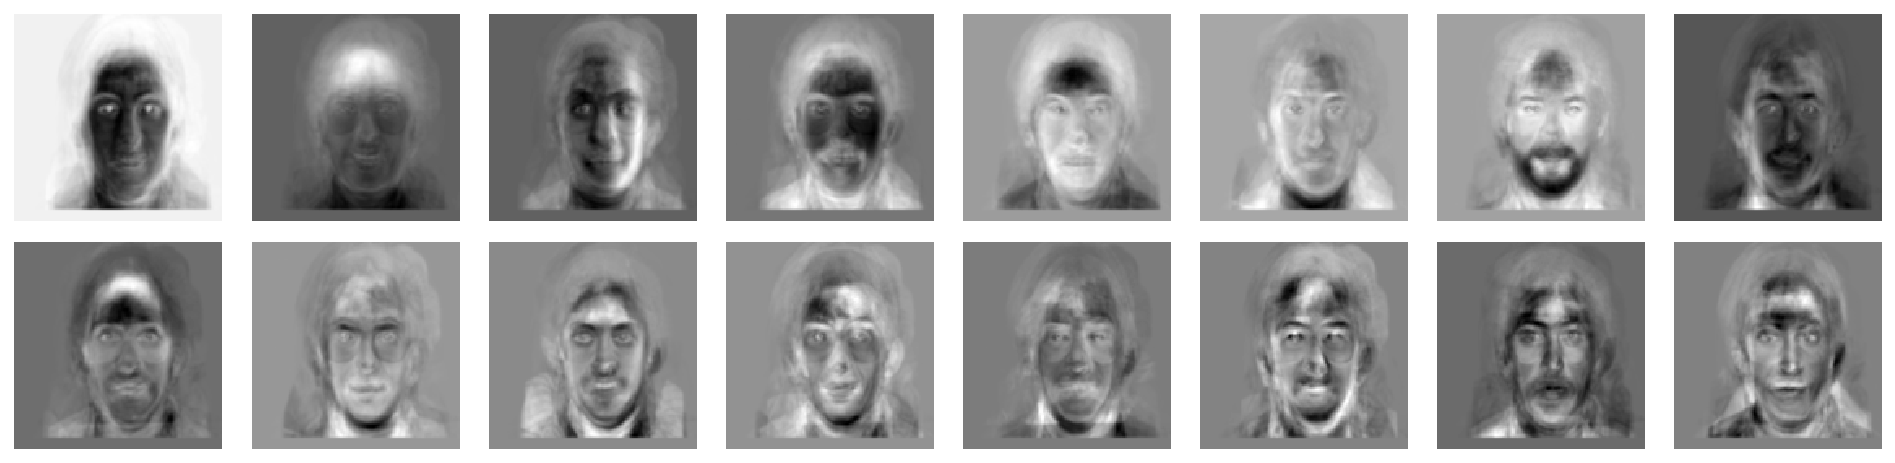

In [0]:
# 99 eigenfaces
fig, axes = plt.subplots(2,8, figsize=(17,4))
for i in range(16):
    raw = eigenfaces_pca[i]
    img = np.reshape(raw, (128, 128))
    axes.flat[i].imshow(img, cmap="gray")
    axes.flat[i].axis('off')
fig.subplots_adjust(hspace=0.1, wspace=0);

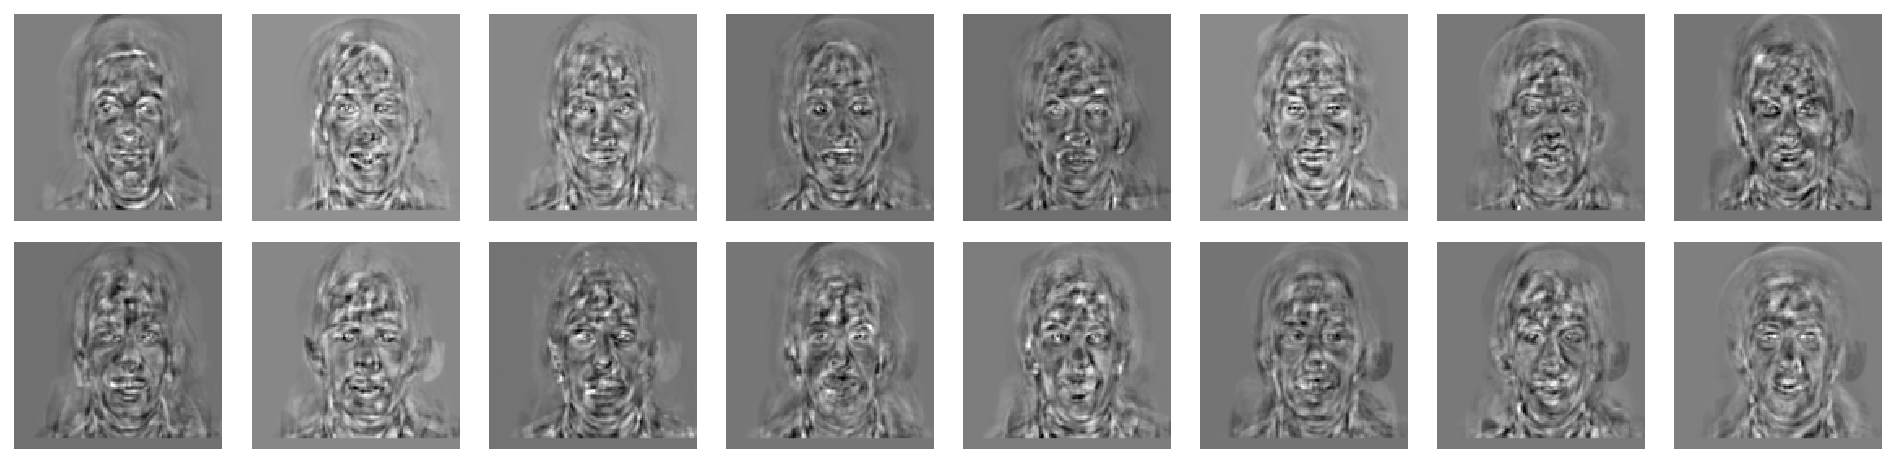

In [0]:
fig, axes = plt.subplots(2,8, figsize=(17,4))
for i in range(16):
    raw = eigenfaces_pca[-i-1]
    img = np.reshape(raw, (128, 128))
    axes.flat[i].imshow(img, cmap="gray")
    axes.flat[i].axis('off')
fig.subplots_adjust(hspace=0.1, wspace=0);

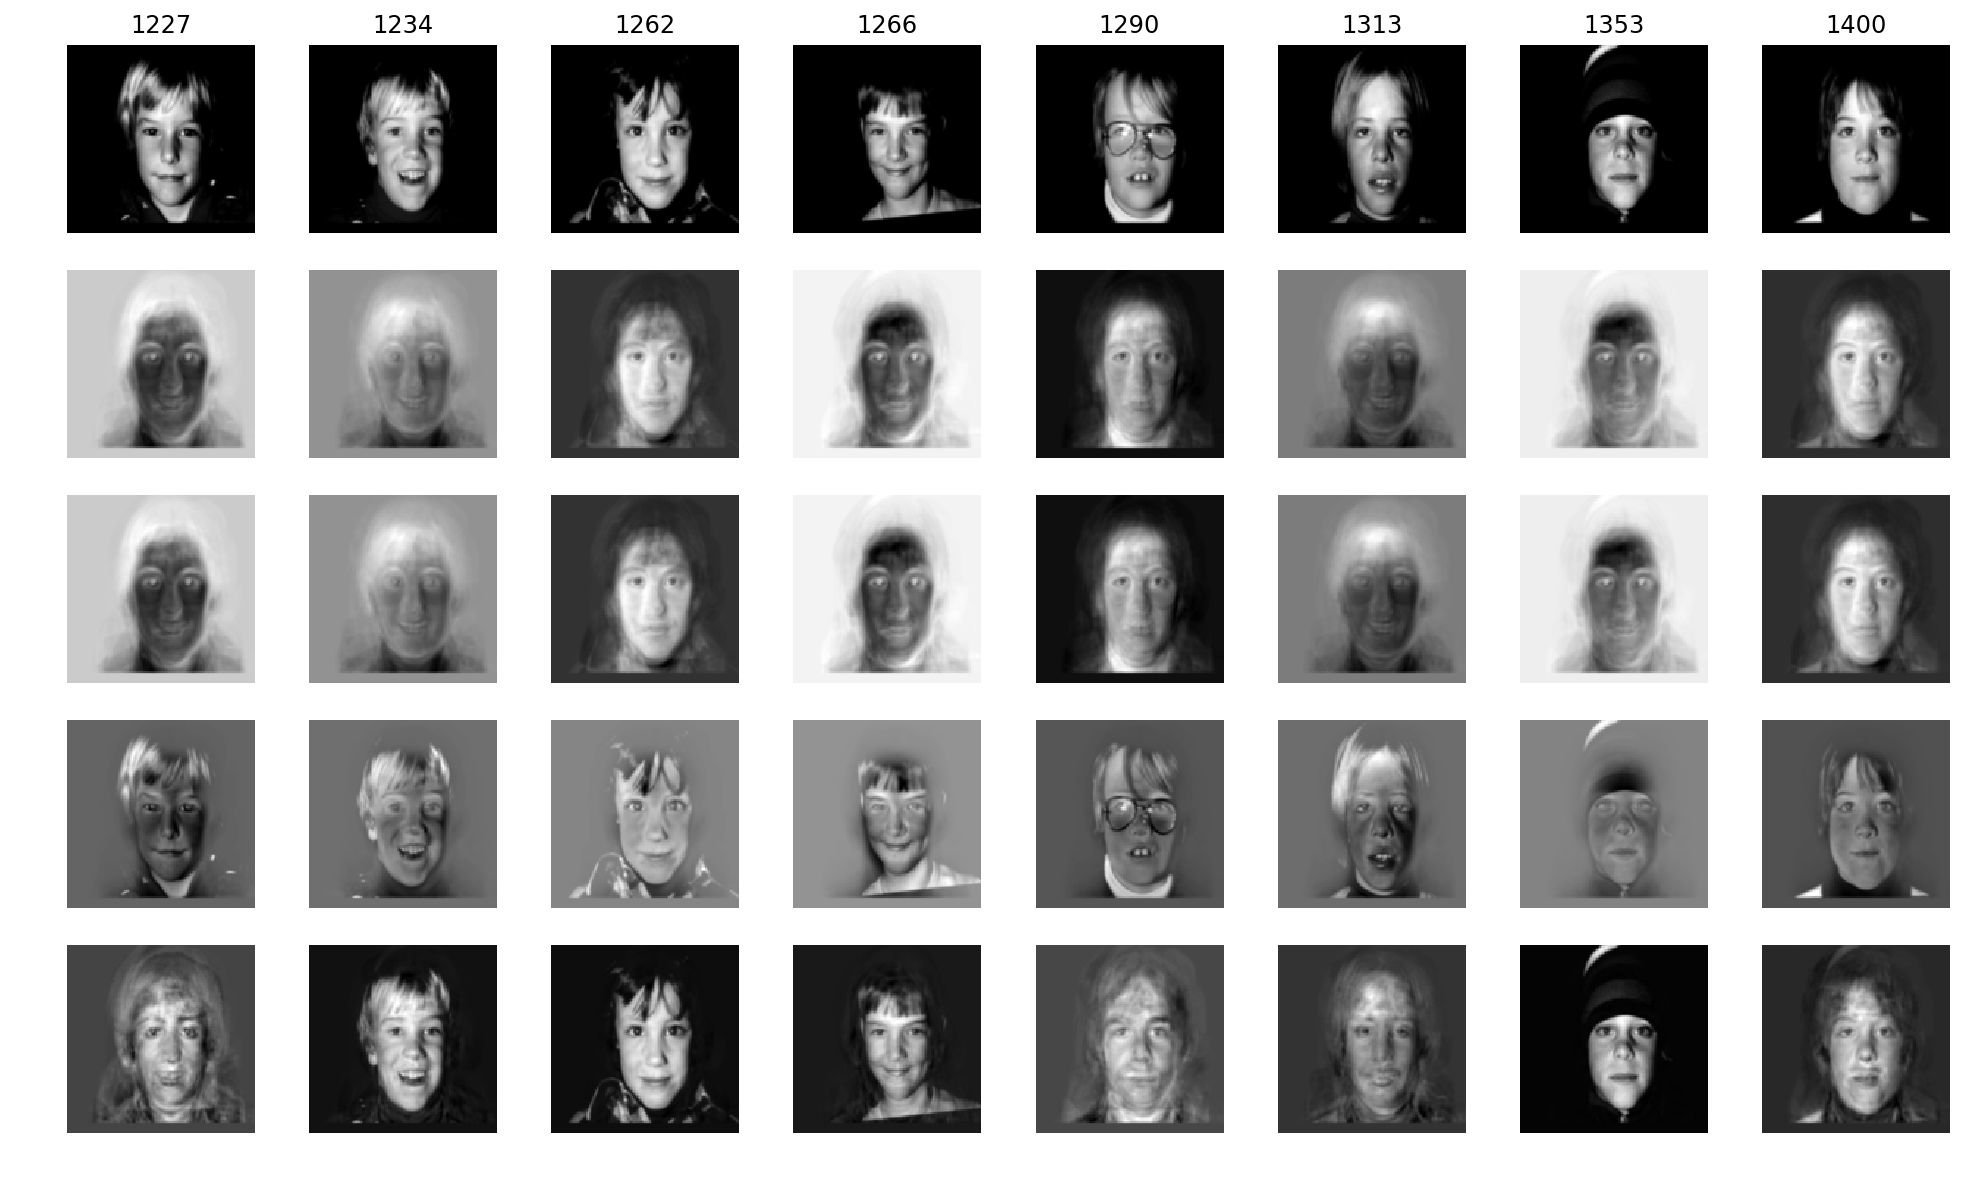

In [0]:
# compare original and reconstructed faces   
fig, axes = plt.subplots(5,8, figsize=(17,10), sharey=True)
count = 0
for i in range(50):
    filename = train_list[i]
    path = '/content/drive/My Drive/data/mitfaces/raw/' + filename
    try:
        raw = np.fromfile(path, dtype='uint8', sep="")
    except FileNotFoundError:
        continue
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count]
    ax.imshow(img, cmap="gray")
    ax.set_title(filename)
    ax.axis('off')
    
##【Caution】skelearn.decomposition.TruncatedSVD or PCA 
## could generate very different results given different parameters

    raw = np.matmul(arr_svd[i], eigenfaces_svd) + meanface
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count+8]
    ax.imshow(img, cmap="gray")
    ax.axis('off')
    
    raw = np.matmul(arr_pca[i], eigenfaces_pca) + meanface
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count+16]
    ax.imshow(img, cmap="gray")
    ax.axis('off')
    
    raw = np.matmul(arr_pca_whiten[i], eigenfaces_pca_whiten) + meanface 
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count+24]
    ax.imshow(img, cmap="gray")
    ax.axis('off')
    
    raw = np.matmul(df_faceR.loc[filename].values, dict_ev['eigenfaces']) + dict_ev['mean_face']
    img = np.reshape(raw, (128, 128))
    ax = axes.flat[count+32]
    ax.imshow(img, cmap="gray")
    ax.axis('off')
    
    count += 1
    if count >= 8:
        break
        
fig.subplots_adjust(hspace=0.2, wspace=0.2);

PCA number of components <= min(number of rows, number of columns)

<img src="https://sandipanweb.files.wordpress.com/2018/01/f2.png" width=400>

# Same training data, different Eigenfaces

<img src='https://github.com/Nov05/pictures/blob/master/gifs/2019-10-18%20eigenfaces.gif?raw=true'>

# Vertical Line Test

## 1.1 Create two graphs, one that passes the vertical line test and one that does not.

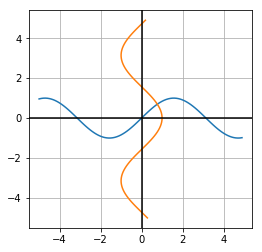

In [0]:
x1 = np.arange(-5, 5, 0.1)
y1 = np.sin(x1)

y2 = np.arange(-5, 5, 0.1)
x2 = np.cos(y2)

plt.figure(figsize=(4, 4))
ax = plt.subplot(111)
ax.grid(True)
plt.plot(x1, y1)
plt.plot(x2, y2)
ax.axhline(0, color='black')
ax.axvline(0, color='black');


## 1.2 Why are graphs that don't pass the vertical line test not considered "functions?"

https://en.wikipedia.org/wiki/Vertical_line_test  
A function can only have one output, y, for each unique input, x. For the graphs that don't pass the vertical line test, a unique input might have mutiple outputs.

# Functions as Relations

## 2.1 Which of the following relations are functions? Why?

\begin{align}
\text{Relation 1: } \{(1, 2), (3, 2), (1, 3)\}
\\
\text{Relation 2: } \{(1, 3), (2, 3), (6, 7)\}
\\
\text{Relation 3: } \{(9, 4), (2, 1), (9, 6)\}
\\
\text{Relation 4: } \{(6, 2), (8, 3), (6, 4)\}
\\
\text{Relation 5: } \{(2, 6), (2, 7), (2, 4)\}
\end{align}

In [0]:
# R1: for input 1, there are two outputs 2 and 3. so it is not a function.
# R2: it is a function.
# R3: for input 9, there are two outputs 4 and 6. so it doesn't qualify as a function.
# R4: for input 6, there are two outputs 2 and 4. so it can't not be a function.
# R5: for input 2, there are two outputs 6 and 4. so it is not a function.

# Functions as a mapping between dimensions


## 3.1 for the following functions what is the dimensionality of the domain (input) and codomain (range/output)?

\begin{align}
m(𝑥_1,𝑥_2,𝑥_3)=(x_1+x_2, x_1+x_3, x_2+x_3)
\\
n(𝑥_1,𝑥_2,𝑥_3,𝑥_4)=(x_2^2 + x_3, x_2x_4)
\end{align}

In [0]:
# 1. for m, 3D to 3D
# 2. for n, 4D to 2D

## 3.2 Do you think it's possible to create a function that maps from a lower dimensional space to a higher dimensional space? If so, provide an example.

In [0]:
# 1. converting low resolution images to high resolution images
# 2. adding columns (creating features) to a dataset

# Vector Transformations

## 4.1 Plug the corresponding unit vectors into each function. Use the output vectors to create a transformation matrix.

\begin{align}
p(\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}) = \begin{bmatrix} x_1 + 3x_2 \\2 x_2 - x_1 \\  \end{bmatrix}
\\
\\
q(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}) = \begin{bmatrix} 4x_1 + x_2 + 2x_3 \\2 x_2 - x_1 + 3x_3 \\ 5x_1 - 2x_3 + x_2  \end{bmatrix}
\end{align}

In [0]:
mp = [[1, 3],
      [2, -1]
     ]
mq = [[4, 1, 2],
      [2, -1, 3],
      [5, -2, 1]
     ]
input1 = [1, 1]
input2 = [2, 3]
input3 = [1, 1, 1]
input4 = [2, 3, 4]
print(np.matmul(mp, input1))
print(np.matmul(mp, input2))
print(np.matmul(mq, input3))
print(np.matmul(mq, input4))

[4 1]
[11  1]
[7 4 4]
[19 13  8]


## 4.2 Verify that your transformation matrices are correct by choosing an input matrix and calculating the result both via the traditional functions above and also via vector-matrix multiplication.

In [0]:
# verified

# Eigenvalues and Eigenvectors

## 5.1 In your own words, give an explanation for the intuition behind eigenvalues and eigenvectors.

https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors  

In linear algebra, an eigenvector or characteristic vector of a linear transformation is a non-zero vector that changes by only a scalar factor when that linear transformation is applied to it. More formally, if T is a linear transformation from a vector space V over a field F into itself and v is a vector in V that is not the zero vector, then v is an eigenvector of T if T(v) is a scalar multiple of v. This condition can be written as the equation

T(v) = lamda * v

where λ is a scalar in the field F, known as the eigenvalue, characteristic value, or characteristic root associated with the eigenvector v.  

In [0]:
# @#$%^&* <- my own words

# alright. an eigenvector is a vector that won't change in direction but will 
# only change in length, when a linear transformation is applied to it. and the 
# length of the vector is its eigenvalue.

# The Curse of Dimensionality

## 6.1 What are some of the challenges of working with high dimensional spaces?

In [0]:
# 1. hard to imagine it with a human brain
# 2. more difficult to make sense of some information
# 3. more calculation

## 6.2 What is the rule of thumb for how many observations you should have compared to parameters in your model?

In [0]:
# rule of thumb = a broadly accurate guide or principle, 
#                 based on experience or practice rather than theory

# like "number of observations should be at least 5 times of number
# of parameters"?

# Principal Component Analysis

## 7.1 Load the UCI Machine Learning Repository's [Iris Dataset](https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv) and use PCA to isolate the dataset's first and second principal components and plot them on a graph. 

In [0]:
import pandas as pd
url = "https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv"
iris = pd.read_csv(url)
print(iris.shape)
iris.head(4)

(150, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa


In [0]:
iris.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [0]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [0]:
means = iris.describe().loc['mean']
stds = iris.describe().loc['std']
means

sepal_length    5.843333
sepal_width     3.054000
petal_length    3.758667
petal_width     1.198667
Name: mean, dtype: float64

In [0]:
# some numpy array features
import numpy as np
v1 = np.array([1, 2, 3, 4])
v2 = np.array([1, 2, 3, 4])
v3 = np.array([[1, 2, 3, 4],
               [2, 4, 6, 8]
             ])
print(v1/v2)
print(v3/v1)
print(v3/2)

[1. 1. 1. 1.]
[[1. 1. 1. 1.]
 [2. 2. 2. 2.]]
[[0.5 1.  1.5 2. ]
 [1.  2.  3.  4. ]]


In [0]:
# check values
df_centered = pd.DataFrame([(np.array(row)-means) 
                           for row in iris.iloc[:,:-1].values])
df_centered.head(2)

,sepal_length,sepal_width,petal_length,petal_width
mean,-0.743333,0.446,-2.358667,-0.998667
mean,-0.943333,-0.054,-2.358667,-0.998667


In [0]:
# 4) Calculate the Variance-Covariance matrix of Z.
Z = pd.DataFrame([(np.array(row)-means) / stds
                  for row in iris.iloc[:,:-1].values])
Z.head(2)

,sepal_length,sepal_width,petal_length,petal_width
0,-0.897674,1.028611,-1.336794,-1.308593
1,-1.139200,-0.124540,-1.336794,-1.308593


In [0]:
print(Z.T.shape)
print(Z.shape)

(4, 150)
(150, 4)


In [0]:
# this is something with unknown meanings, ignore it
Y = pd.DataFrame([(np.array(row)-means)/(stds**2)
                  for row in iris.iloc[:,:-1].values])
ZY = np.matmul(Y.T.values, Y.values)
ZY

array([[ 217.29824962,  -45.3871493 ,   88.90234161,  192.85633652],
       [ -45.3871493 ,  792.53621585,  -81.89987551, -160.54615646],
       [  88.90234161,  -81.89987551,   47.8610385 ,  106.53318235],
       [ 192.85633652, -160.54615646,  106.53318235,  255.83162274]])

## Variance-Covariance  

<img src="https://cdn.educba.com/academy/wp-content/uploads/2019/05/Covariance-Formula.jpg" width="300">

In [0]:
# 4) Calculate the Variance-Covariance matrix of Z.
# 【Issue】I think it should be Correlation-Coefficient matrix of Z?
Z = pd.DataFrame([(np.array(row)-means) / stds
                  for row in iris.iloc[:,:-1].values])
NCORR = np.matmul(Z.T.values, Z.values)
print(NCORR)

[[149.         -16.29601824 129.89136944 121.87509137]
 [-16.29601824 149.         -62.65689836 -53.12506935]
 [129.89136944 -62.65689836 149.         143.45080746]
 [121.87509137 -53.12506935 143.45080746 149.        ]]


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.cov.html  
Returns the covariance matrix of the DataFrame’s time series. The covariance is normalized by N-1.  

In [0]:
# see how far it is from a covariance matrix
print(iris.cov(), '\n')
W = pd.DataFrame([(np.array(row)-means)
                  for row in iris.iloc[:,:-1].values])
COV = np.matmul(W.T.values, W.values)/(iris.shape[0]-1)
print(COV)

              sepal_length  sepal_width  petal_length  petal_width
sepal_length      0.685694    -0.039268      1.273682     0.516904
sepal_width      -0.039268     0.188004     -0.321713    -0.117981
petal_length      1.273682    -0.321713      3.113179     1.296387
petal_width       0.516904    -0.117981      1.296387     0.582414 

[[ 0.68569351 -0.03926846  1.27368233  0.5169038 ]
 [-0.03926846  0.18800403 -0.32171275 -0.11798121]
 [ 1.27368233 -0.32171275  3.11317942  1.29638747]
 [ 0.5169038  -0.11798121  1.29638747  0.58241432]]


In [0]:
iris.sepal_length.var()

0.6856935123042505

## Correlation Coefficient  

<img src="http://www.stat.yale.edu/Courses/1997-98/101/cor.gif" width="300">

In [0]:
np.matmul(Z.T.values, Z.values) / (iris.shape[0]-1)

array([[ 1.        , -0.10936925,  0.87175416,  0.81795363],
       [-0.10936925,  1.        , -0.4205161 , -0.35654409],
       [ 0.87175416, -0.4205161 ,  1.        ,  0.9627571 ],
       [ 0.81795363, -0.35654409,  0.9627571 ,  1.        ]])

In [0]:
iris.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


**What are the Eigenvectors and Eigenvalues of the Variance-Covariance Matrix?**  

In [0]:
# 5) Calculate the Eigenvectors and Eigenvalues of the Variance-Covariance Matrix.

# What are the Eigenvectors and Eigenvalues of the Variance-Covariance Matrix? 
# The eigenvectors are those that run along the dimensions that maximize the 
# variance along that dimension. Remember our rotated elipse example? When 
# we moved our elipse off of the x and y axis we then didn't know what line 
# we should project the points onto so that they we could collapse the dimension 
# of least variance. Well now we do!

# thos are not eigenvalues and eigenvectors. ignore them.
eigenvalues, eigenvectors = np.linalg.eig(NCORR)
print(eigenvalues, '\n\n', eigenvectors)

[433.71189448 137.26191868  21.95563847   3.07054838] 

 [[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]


In [0]:
# get the Eigenvectors and Eigenvalues of the Correlation Coefficience matrix
eigenvalues, eigenvectors = np.linalg.eig(iris.corr())
print(eigenvalues, '\n\n', eigenvectors, '\n')
# percentage of variance covered by each PCA
print("Variance coverage ratio:", eigenvalues / eigenvalues.sum())

[2.91081808 0.92122093 0.14735328 0.02060771] 

 [[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]] 

Variance coverage ratio: [0.72770452 0.23030523 0.03683832 0.00515193]


In [0]:
# get the Eigenvectors and Eigenvalues of the Variance-Covariance Matrix
eigenvalues, eigenvectors = np.linalg.eig(iris.cov())
print(eigenvalues, '\n\n', eigenvectors, '\n')
# percentage of variance covered by each PCA
print("Variance coverage ratio:", eigenvalues / eigenvalues.sum())

[4.22484077 0.24224357 0.07852391 0.02368303] 

 [[ 0.36158968 -0.65653988 -0.58099728  0.31725455]
 [-0.08226889 -0.72971237  0.59641809 -0.32409435]
 [ 0.85657211  0.1757674   0.07252408 -0.47971899]
 [ 0.35884393  0.07470647  0.54906091  0.75112056]] 

Variance coverage ratio: [0.92461621 0.05301557 0.01718514 0.00518309]


In [0]:
# eigenvector matrix feature: E^-1 = E^T
# a.k.a. its inverse matrix = itself
np.dot(np.linalg.inv(eigenvectors), eigenvectors).round(10)

array([[ 1.,  0., -0., -0.],
       [ 0.,  1., -0.,  0.],
       [-0.,  0.,  1., -0.],
       [-0.,  0., -0.,  1.]])

In [0]:
# numpy.matmul() features
a1 = np.array([[1, 2, 3],
               [4, 5, 6]
              ])
a2 = np.array([[2, 0],
               [0, 3]
              ])
print(np.matmul(a2.T, a1))
print(np.matmul(a1.T, a2).T)

[[ 2  4  6]
 [12 15 18]]
[[ 2  4  6]
 [12 15 18]]


In [0]:
print(iris.head(), '\n')
print(df_center.shape, eigenvectors.shape)
df_pca = pd.DataFrame(np.dot(df_center.values, eigenvectors[:2,:].T))
df_pca['species'] = iris['species']
df_pca.head()

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa 



,0,1,species
0,0.491949,-1.347388,setosa
1,0.747901,-0.966078,setosa
2,0.602375,-1.155208,setosa
3,0.515670,-0.954727,setosa
4,0.390136,-1.412132,setosa


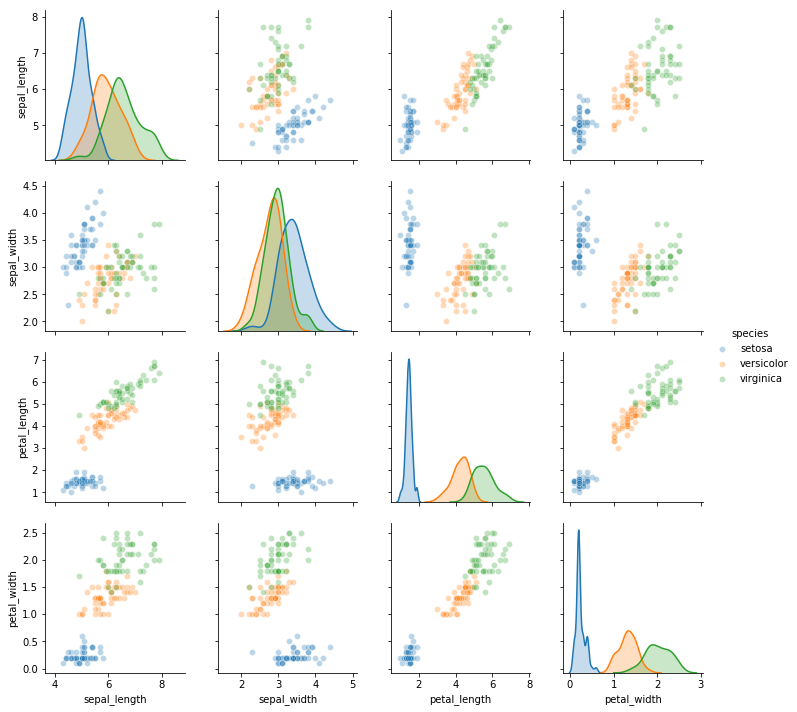

In [0]:
import seaborn as sns
sns.pairplot(data=iris, hue='species', 
             plot_kws={'alpha': 0.3});

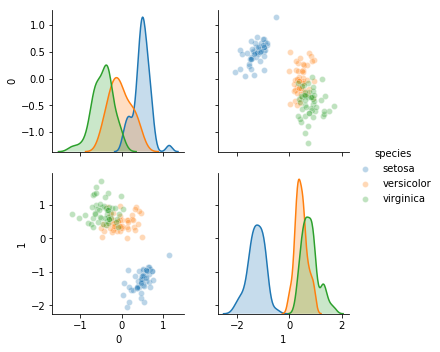

In [0]:
# seaborn pairplot for PCAs
sns.pairplot(data=df_pca, hue='species',
             plot_kws={'alpha': 0.3});

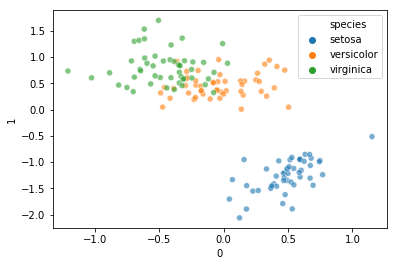

In [0]:
# seaborn scatterplot for the 1st PCA and the 2nd PCA
sns.scatterplot(x=0, y=1, data=df_pca, hue='species',
                alpha=0.6);

# Stretch Goal

## 1) Do NOT work on the stretch goal until you feel like you have a firm grasp of eigenvectors, eigenvalues, and PCA. Prioritize self-study over the stretch goal if you are not comfortable with those topics yet.

## 2) Explore further the intuition behind eigenvalues and eigenvectors by creating your very own eigenfaces:

<img src="https://i.pinimg.com/236x/1c/f1/01/1cf101a9859437a5d096a04b05be06b4--faces-tattoo.jpg" width="400">

You don't necessarily have to use this resource, but this will get you started:   
https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/  

In [0]:
!wget https://upload.wikimedia.org/wikipedia/zh/thumb/3/34/Lenna.jpg/200px-Lenna.jpg -O lenna.jpg

--2019-06-20 22:25:48--  https://upload.wikimedia.org/wikipedia/zh/thumb/3/34/Lenna.jpg/200px-Lenna.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13753 (13K) [image/jpeg]
Saving to: ‘lenna.jpg’

lenna.jpg           100%[===================>]  13.43K  --.-KB/s    in 0s      

2019-06-20 22:25:48 (65.5 MB/s) - ‘lenna.jpg’ saved [13753/13753]



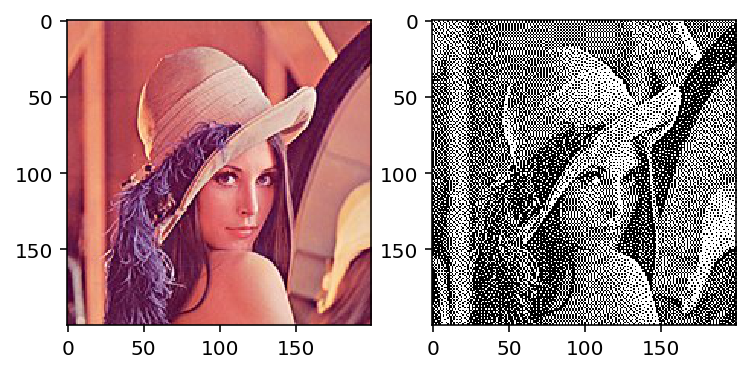

In [0]:
filename = "lenna.jpg"
im = PIL.Image.open(filename)
im.save('lenna_color.png')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

img = Image.open("lenna_color.png") # open colour image
ax1.imshow(img)
img = img.convert('1') # convert image to black and white
img.save('lenna.png')
ax2.imshow(img, cmap="gray");

## Some other stuff

In [0]:
# Create a list of 50 random floats and add them to a dataframe
N = 50
x = np.random.rand(N)*100

# Crete Dataframe
data = {"x": x}
df = pd.DataFrame(data)
df.head(3)

,x
0,4.000540
1,62.875611
2,82.029254


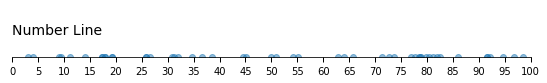

In [0]:
# Plot the floats on a number line

# Setup a plot such that only the bottom spine is shown
def setup(ax):
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00)
    ax.tick_params(which='major', length=5)
    ax.tick_params(which='minor', width=0.75)
    ax.tick_params(which='minor', length=2.5)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.patch.set_alpha(0.0)
    
plt.figure(figsize=(8, 6))
n = 8

# Create some y values to satisfy matplotlib
df['y'] = pd.Series(list(np.zeros(50)))

# Multiple Locator tick mark settings
ax = plt.subplot(n, 1, 2)
setup(ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.text(0.0, 0.5, "Number Line", fontsize=14,
        transform=ax.transAxes)

# Push the top of the top axes outside the figure because we only show the
# bottom spine.
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=1.05)
plt.scatter(df.x, df.y, alpha=0.5)

plt.show()

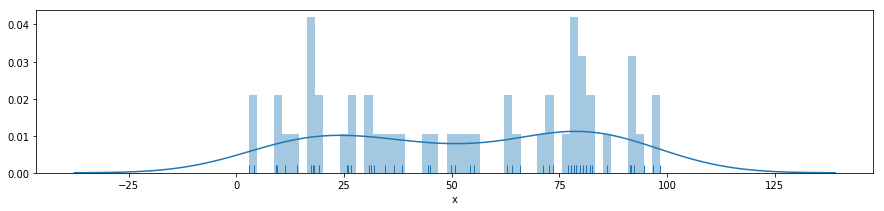

In [0]:
plt.figure(figsize=(15,3))
sns.distplot(df.iloc[:,0], 
             bins=len(df.iloc[:,0]), 
             rug=True);

https://seaborn.pydata.org/generated/seaborn.rugplot.html  

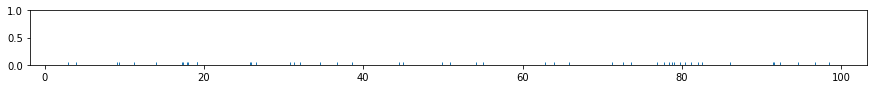

In [0]:
plt.figure(figsize=(15,1))
sns.rugplot(df.iloc[:,0]);

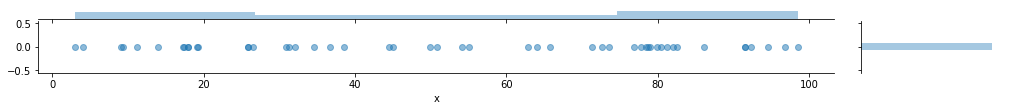

In [0]:
grid = sns.jointplot(df.iloc[:,0], [0]*len(df.iloc[:,0]),
                     alpha=0.5
                    )
grid.fig.set_figwidth(15)
grid.fig.set_figheight(1)